In [28]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt

from astropy.modeling import models, fitting
from astropy.nddata import Cutout2D
from glob import glob 
from PIL import Image     #For jpg only
from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from photutils.detection import DAOStarFinder


# Star Roundness

## Why bother with this ?

It was cloudy, and I was bored.... it seemed like a good idea at the time.
Plus I have never taken an image > 20s ... I was curious if I could.

## Purpose

Can I detect signs that on longer exposures my stars as less round ?? 

## Equipment
My DSLR sits on on a StarAdventurer - sort of Polar aligned.
I use EKOS (remote Rasberry Pi) talking via Cat 5 to my Mac running KStars.


## Camera Settings

My Nikon D600 (yes the horror model), 
ISO 320
Lense 85mm F1.8 set to F2

## Exposure Times 

I took 

   - 10s
   - 20s
   - 30s
   - 40s
   - 50s

5 exposures using JPG Fine (only for this usually I would use FITS/NEF((RAW)).

## Programming Flow 

 - With each file in Directory do
   - Convert to grey scale
   - Calculate the background
   - remove backgroup from image and calculate the possible star locations 
   - using my Nikon Camera image specs
      - crop the possible stars towards the centre picking the brightest stars 
      - output roundness1 and roundness2 

    



In [ ]:
def file_list(dir:str=".",file_spec:str="*.fits") -> list:
    files=glob(dir+"/"+file_spec)
    return files

def plot_data(img_data,star_df,title="Star Plot"):
    if star_df is not None:
        #print(star_df)
        # Plot the image with detected stars overlaid
        plt.figure(figsize=(10, 10))
        norm = simple_norm(img_data, 'sqrt', percent=99)
        plt.imshow(img_data, cmap='gray', norm=norm)
        plt.colorbar()
        plt.scatter(star_df['xcentroid'], star_df['ycentroid'], s=30, edgecolor='red', facecolor='none')
        plt.xlabel('X Pixel')
        plt.ylabel('Y Pixel')
        plt.title(title)
        plt.show()
    else:
        print("No stars detected.")

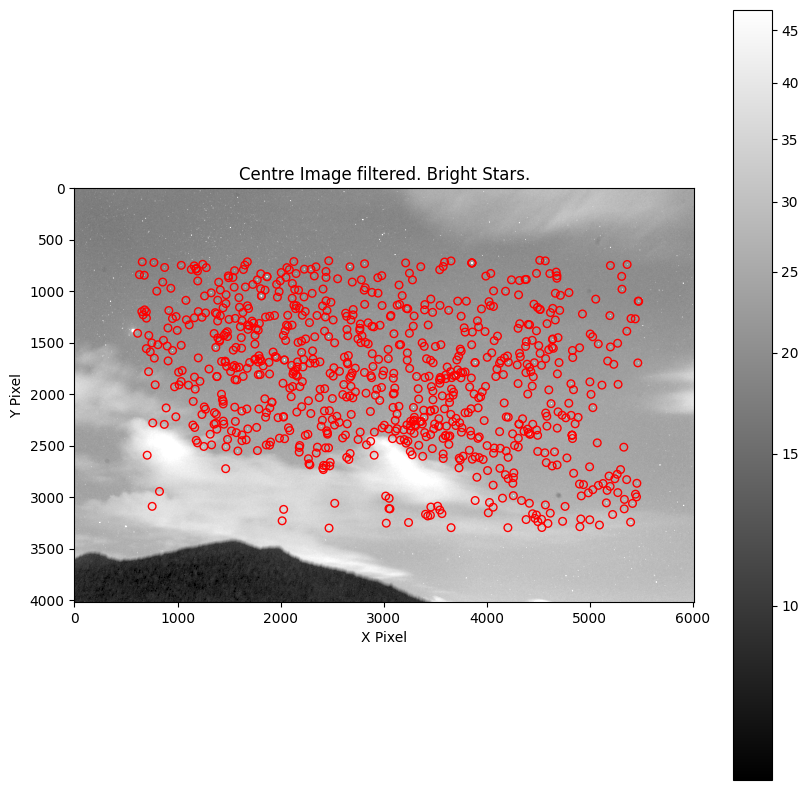

Image has mean roundness of 0.11837281739308796 r1
Image has mean roundness of 0.15927330254754926 r2
Image has mean roundness of 0.060930124061594704 r1
Image has mean roundness of 0.12378238364072254 r2
Image has mean roundness of 0.21393870635321674 r1
Image has mean roundness of 0.15885071204110884 r2
Image has mean roundness of 0.40176761293957436 r1
Image has mean roundness of 0.28162623991133817 r2
Image has mean roundness of 0.03859267386484217 r1
Image has mean roundness of 0.11778104721246742 r2
------------------------Summary----------------
R1 mean 0.1667203869224632
R2 mean 0.16826273707063724


In [26]:
files=file_list("./50s","*.jpg")
r1=[]
r2=[]
bFirstTime=True
for f in files:
    
    image_data = Image.open(f).convert('L') # Convert to grayscale if needed
    # Calculate background statistics
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)  # sigma clipping for robust statistics

    # Initialize DAOStarFinder with a threshold above the background noise
    threshold = 5. * std  # Adjust based on your image
    daofind = DAOStarFinder(fwhm=3.0, threshold=threshold)
    star_sources = daofind(image_data - median)
    df=star_sources.to_pandas()
    #print(f"{f} Source Image has {len(df)} possible stars")
    #df.mag>=df.mag.describe()['mean']+df.mag.describe()['std']
    df_centre=df[(df.xcentroid.between(x_limit[0], x_limit[1]))&
                 (df.ycentroid.between(y_limit[0], y_limit[1]))&
                 (df.mag<=df.mag.describe()['75%'])
                 ]
    #print(f"{f} Camera Sensor clipped table now has {len(df_centre)} rows")
    if bFirstTime:
        plot_data(image_data,Table.from_pandas(df_centre),"Centre Image filtered. Bright Stars.")
        bFirstTime = False 
    print(f"Image has mean roundness of {df_centre.roundness1.describe()['mean']} r1")
    print(f"Image has mean roundness of {df_centre.roundness2.describe()['mean']} r2")
    r1.append(df_centre.roundness1.describe()['mean'])
    r2.append(df_centre.roundness2.describe()['mean'])

print("------------------------Summary----------------")
print(f"R1 mean {statistics.mean(r1)}")
print(f"R2 mean {statistics.mean(r2)}")


In [27]:
# Nikon Sensor is 6014 by 4014 
# Assuming there is fringing on the outside of the lense - only take data towards the centre
# These values are not chosen with any knowledge except a decent(?) guess
x_limit=[600,5500]
y_limit=[700,3300] 

# Summary 

| Exposure Length | Round1  | Round2 |
|-----------------|---------|--------|
|   10            |   0.114 |  0.129 |
|   20            |   0.125 |  0.128 |
|   30            |   0.124 |  0.136 |
|   40            |   0.073 |  0.147 |
|   50            |   0.167 |  0.168 |

The stars are becoming less round the longer we are exposing the image.

Next time I will try with a longer focal length - as this should show the problems quicker.

0.114335639602643